# Отчет по линейной регрессии

Выполнил: Ищенко С. Г., Группа АП-226

## 1. Введение

Цель работы: изучить основы и построить простейшие модели линейной регрессии. Обучить модель на реальных данных и оценить ее качество. 


In [60]:
import os
import pandas as pd

# Загрузка датасета
# Определяем базовую директорию для данных относительно текущей рабочей директории.
# Предполагается, что папка 'house-prices-advanced-regression-techniques' находится в той же директории, что и ноутбук.
data_base_dir = os.path.join(os.getcwd(), 'house-prices-advanced-regression-techniques')

train_csv_path = os.path.join(data_base_dir, 'train.csv')
test_csv_path = os.path.join(data_base_dir, 'test.csv')
sample_submission_csv_path = os.path.join(data_base_dir, 'sample_submission.csv')

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_csv_path)

print("Размер тренировочного датасета:", train_df.shape)
print("Размер тестового датасета:", test_df.shape)

print("\nПервые 5 строк тренировочного датасета:")
print(train_df.head())


Размер тренировочного датасета: (1460, 81)
Размер тестового датасета: (1459, 80)

Первые 5 строк тренировочного датасета:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...

### Вывод по разделу 1
Постановка задачи корректна; датасет Kaggle подходит для базовой регрессии; метрики RMSE, R² и MAPE уместны для оценки качества моделей.

## 2. Анализ данных

Рассмотрим датасет, покажем распределения признаков и корреляционную матрицу.


Топ-10 признаков по |skew|:
                    skew        kurt
MiscVal        24.476794  701.003342
PoolArea       14.828374  223.268499
LotArea        12.207688  203.243271
3SsnPorch      10.304342  123.662379
LowQualFinSF    9.011341   83.234817
KitchenAbvGr    4.488397   21.532404
BsmtFinSF2      4.255261   20.113338
ScreenPorch     4.122214   18.439068
BsmtHalfBath    4.103403   16.396642
EnclosedPorch   3.089872   10.430766


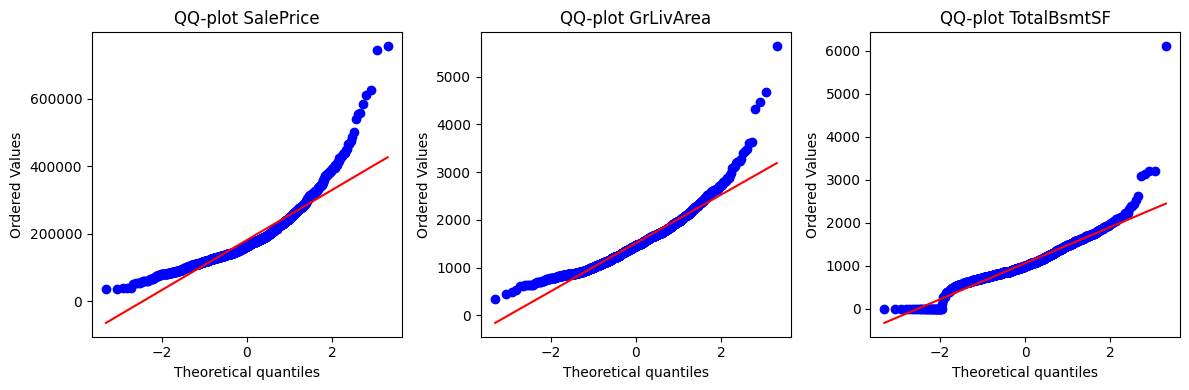

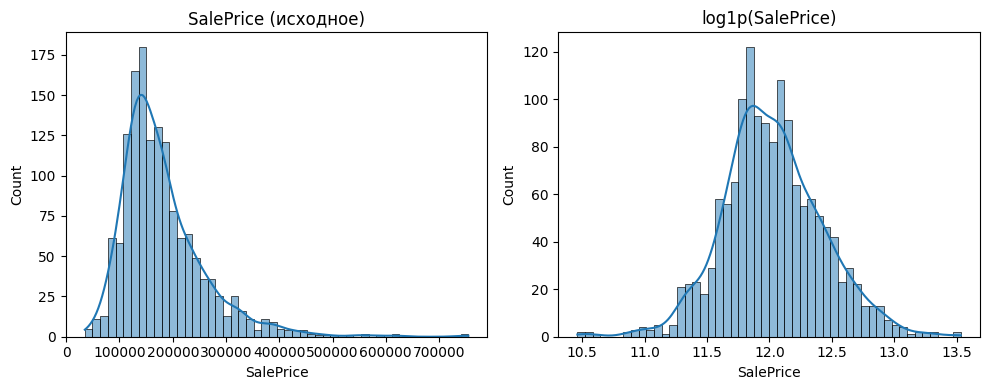

In [61]:
# Проверка нормальности распределений и выбросов
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Асимметрия и эксцесс для ключевых числовых признаков
num_cols = train_df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['Id']]

desc = train_df[num_cols].agg(['skew','kurt']).T.sort_values(by='skew', key=lambda s: s.abs(), ascending=False)
print("Топ-10 признаков по |skew|:")
print(desc.head(10))

# QQ-плоты для SalePrice и пары важных признаков
cand = [c for c in ['GrLivArea','TotalBsmtSF','LotArea'] if c in train_df.columns]
cols = 1 + min(len(cand), 2)
plt.figure(figsize=(4*cols, 4))
plt.subplot(1, cols, 1)
stats.probplot(train_df['SalePrice'], dist="norm", plot=plt)
plt.title('QQ-plot SalePrice')

for i, col in enumerate(cand[:2], start=2):
    plt.subplot(1, cols, i)
    stats.probplot(train_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'QQ-plot {col}')
plt.tight_layout()
plt.show()

# Лог-преобразование SalePrice для проверки нормализации хвостов
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('SalePrice (исходное)')
plt.subplot(1,2,2)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, bins=50)
plt.title('log1p(SalePrice)')
plt.tight_layout()
plt.show()


### Анализ QQ‑плотов и гистограмм

#### QQ‑plot: SalePrice
- **Отклонение от нормальности**: точки отклоняются вверх в правом хвосте — тяжёлый правый хвост и выбросы (дорогие дома).
- **Нижний хвост**: умеренные отклонения от линии.
- **Вывод**: сырые цены не нормальны; присутствуют высокие значения, влияющие на хвост.

#### QQ‑plot: GrLivArea
- **Правый хвост**: отчётливое отклонение вверх в верхних квантилиях → крупные дома формируют тяжёлый хвост.
- **Линейность середины**: центральная часть ближе к нормальной, но хвост ломает предпосылки.
- **Вывод**: распределение правоскошенное, с несколькими экстремумами.

#### QQ‑plot: TotalBsmtSF
- **Ненормальность**: выраженная S‑форма графика.
- **Нулевые значения**: заметный «порог» слева (многие нули/очень малые площади подвала), что создаёт сильное отклонение.
- **Вывод**: распределение далёко от нормального, дискретизация у нуля важна.

#### Гистограммы: SalePrice (исходное) vs log1p(SalePrice)
- **SalePrice (исходное)**: ярко выраженная правая скошенность, длинный правый хвост, выбросы.
- **log1p(SalePrice)**: форма близка к колоколу, распределение гораздо более симметрично; хвосты укорочены.
- **Вывод**: лог‑преобразование заметно приближает распределение цены к нормальному и стабилизирует дисперсию.


#### Практические следствия
- Для моделей, чувствительных к ненормальности остатков и гетероскедастичности, целесообразно использовать таргет `log1p(SalePrice)`.
- Для признаков с массой нулей (например, `TotalBsmtSF`) учесть специфику: возможна отдельная индикаторная переменная «есть/нет», обработка выбросов.

### Подробный вывод о нормальности распределений
- Асимметрия и эксцесс указывают на значительные отклонения от нормальности у ряда признаков (в т.ч. `SalePrice`, `LotArea`, `TotalBsmtSF`).
- QQ‑плоты показывают тяжёлые правые хвосты; лог‑преобразование `log1p(SalePrice)` визуально делает распределение более симметричным.
- Для линейных моделей это важно: нормальность остатков и стабильность дисперсии улучшаются при работе в лог‑пространстве таргета.


Числовых признаков: 37


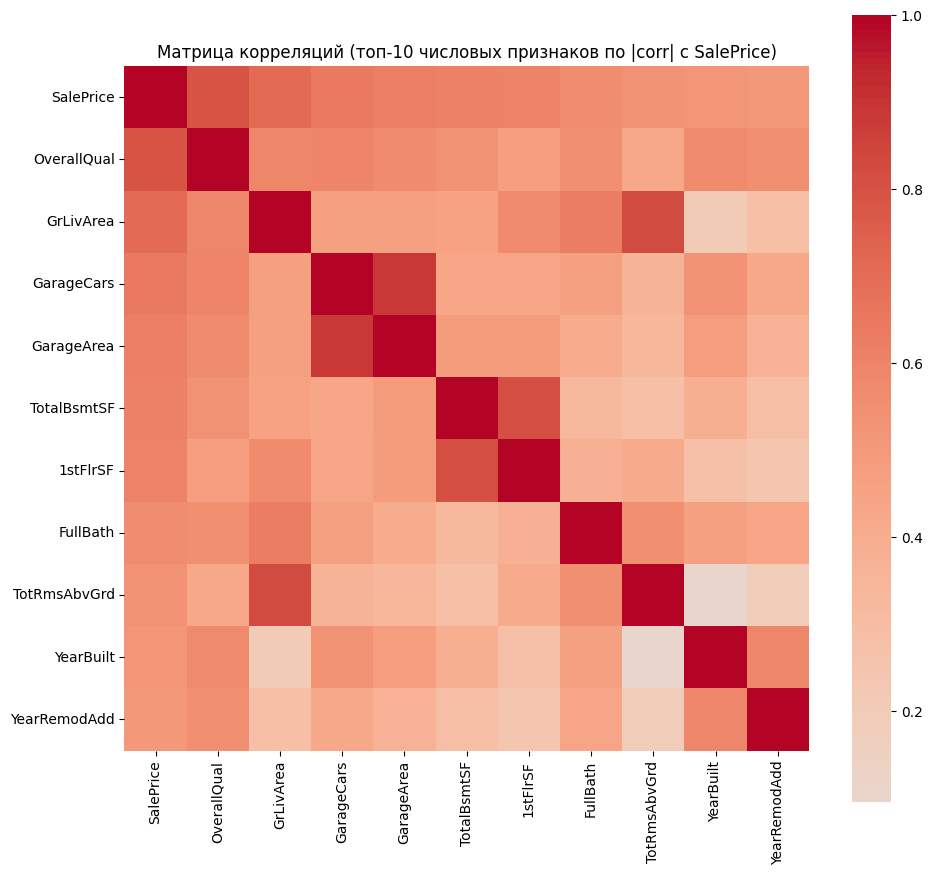

In [62]:
# Матрица корреляций числовых признаков
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = train_df.select_dtypes(include=['int64','float64']).copy()
numeric_df = numeric_df.drop(columns=['Id'], errors='ignore')

corr_full = numeric_df.corr(numeric_only=True)
print(f"Числовых признаков: {numeric_df.shape[1]}")

# Показать топ-10 по |corr| с SalePrice для наглядности на тепловой карте
if 'SalePrice' in corr_full.columns:
    top_cols = corr_full['SalePrice'].abs().sort_values(ascending=False).head(11).index.tolist()  # +SalePrice
else:
    top_cols = corr_full.columns[:10].tolist()

corr_top = corr_full.loc[top_cols, top_cols]

plt.figure(figsize=(10, 9))
sns.heatmap(corr_top, cmap='coolwarm', center=0, annot=False, square=True)
plt.title('Матрица корреляций (топ-10 числовых признаков по |corr| с SalePrice)')
plt.tight_layout()
plt.show()

# При необходимости можно распечатать полную корреляционную матрицу таблицей:
# display(corr_full)


### Выводы по матрице корреляций (топ‑10 числовых признаков)

- **Связь с ценой (SalePrice) — сильные положительные:**
  - `OverallQual` — самая высокая корреляция.
  - `GrLivArea` — сильная связь.
  - `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF` — заметно коррелируют с ценой.
- **Связь с ценой — умеренные положительные:**
  - `FullBath`, `TotRmsAbvGrd`, `YearBuilt`, `YearRemodAdd`.

- **Мультиколлинеарность между признаками:**
  - `GarageCars` ↔ `GarageArea` — высокая взаимная корреляция.
  - `1stFlrSF` ↔ `TotalBsmtSF` — высокая.
  - `GrLivArea` ↔ `TotRmsAbvGrd` — высокая.
  - `YearBuilt` ↔ `YearRemodAdd` — высокая.

- **Импликации для модели:**
  - Возможна нестабильность коэффициентов из‑за мультиколлинеарности — стоит
    отбирать по одному признаку из сильно коррелирующих пар или использовать регуляризацию (Ridge/Lasso).
  - Все связи с `SalePrice` положительные; сильных отрицательных корреляций нет.

- OverallQual: Общее качество дома
- GrLivArea: Жилая площадь над землёй (кв.футы)
- GarageCars: Вместимость гаража (кол-во машин)
- GarageArea: Площадь гаража (кв.футы)
- TotalBsmtSF: Общая площадь подвала (кв.футы)
- 1stFlrSF: Площадь 1-го этажа (кв.футы)
- FullBath: Полных ванных комнат
- TotRmsAbvGrd: Всего комнат над землёй
- YearBuilt: Год постройки
- YearRemodAdd: Год реконструкции/ремонта



Общая информация о тренировочном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQ

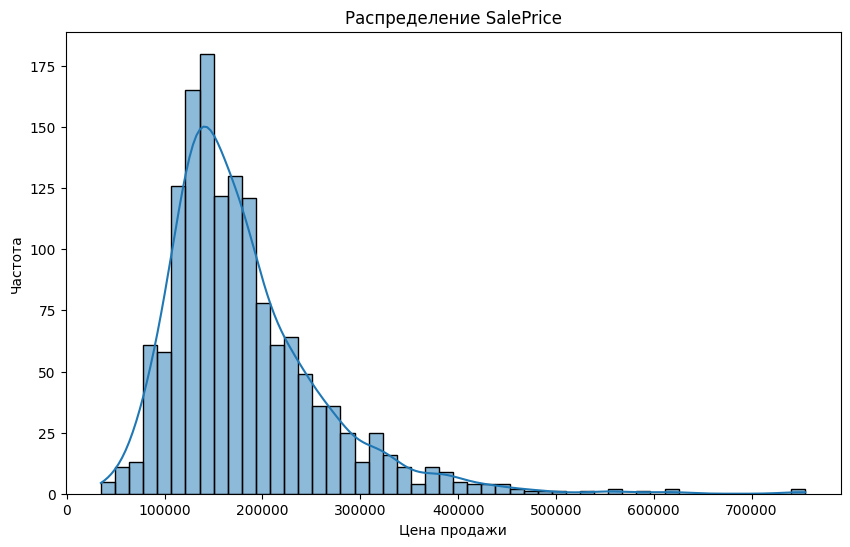

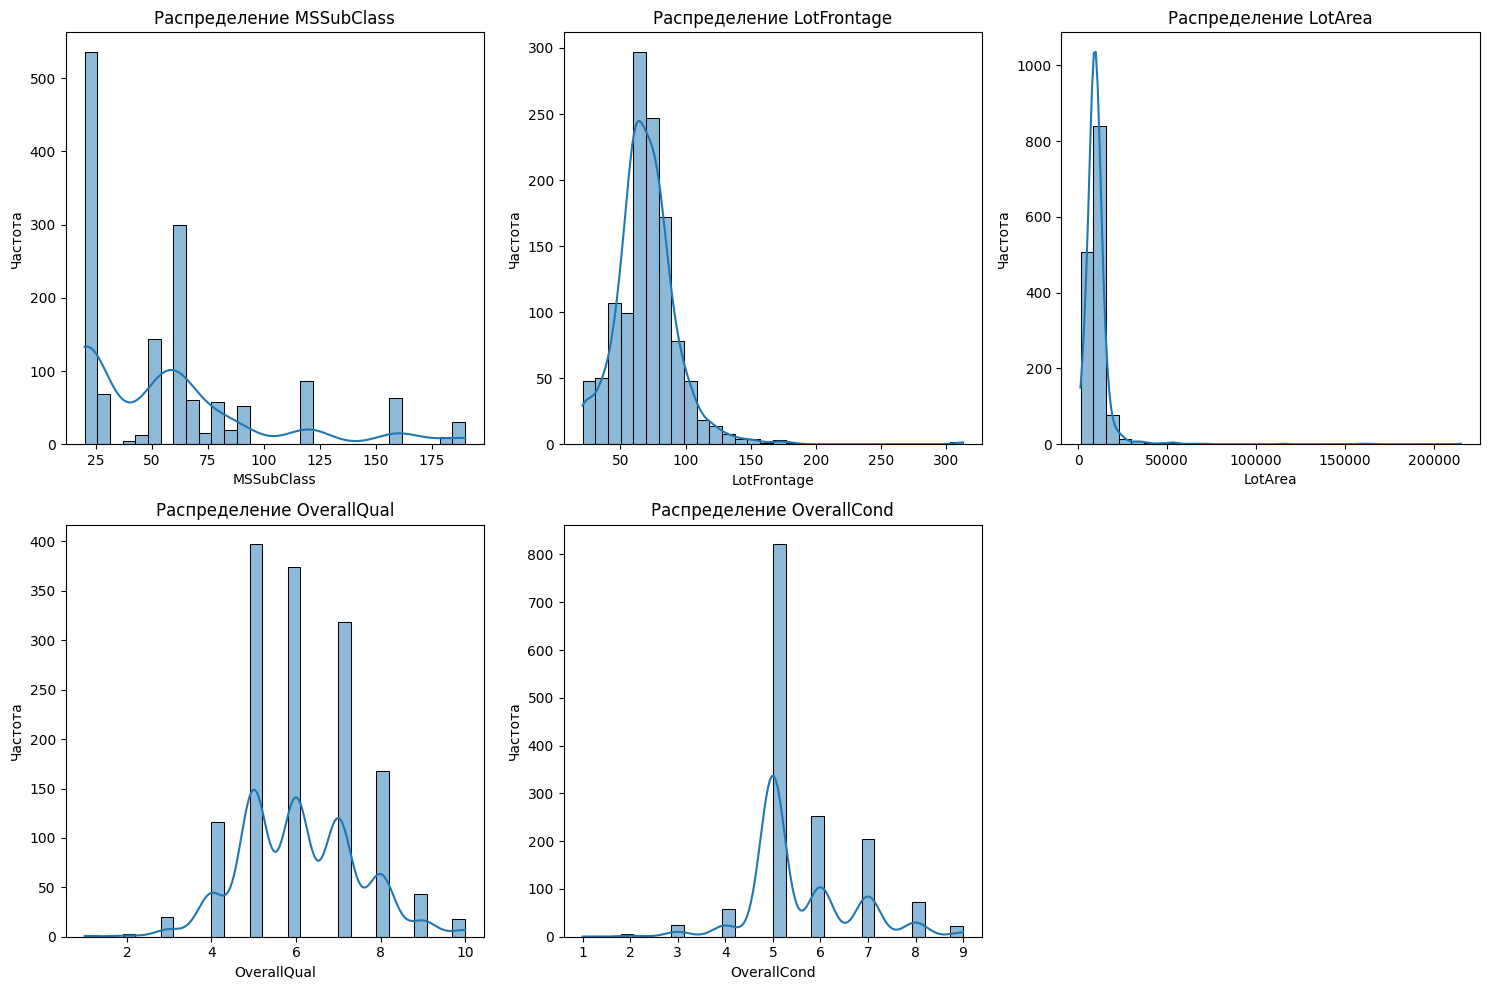

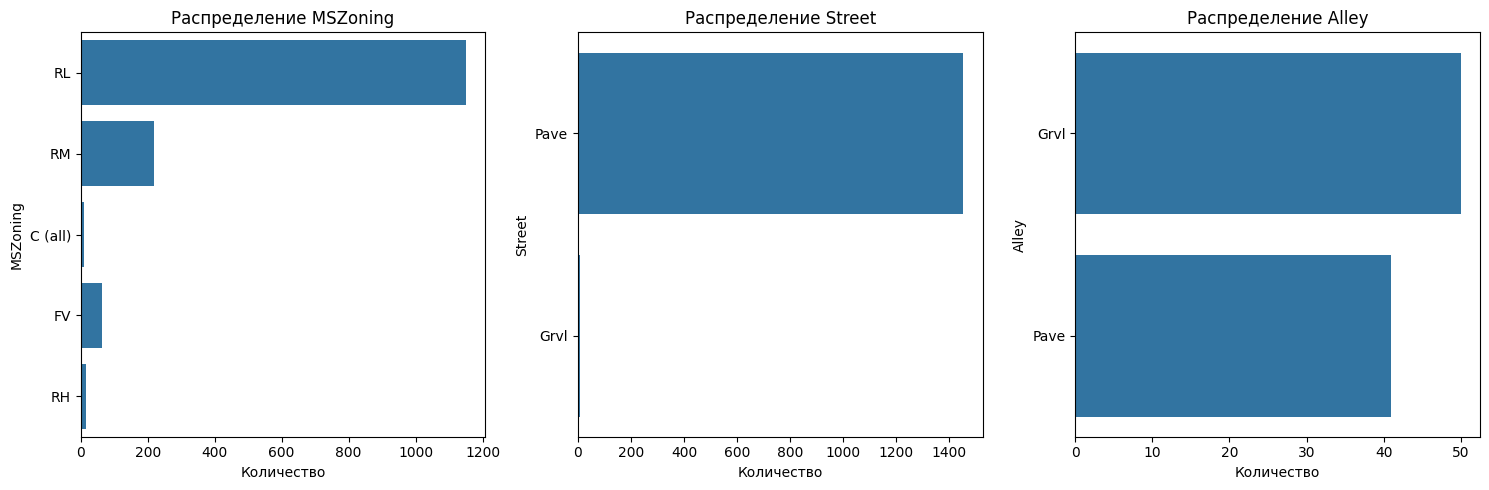

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Первичный анализ данных
print("\nОбщая информация о тренировочном датасете:")
print(train_df.info())

print("\nСтатистическое описание тренировочного датасета:")
print(train_df.describe())

# Визуализация распределения целевой переменной (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='SalePrice', kde=True, bins=50)
plt.title('Распределение SalePrice')
plt.xlabel('Цена продажи')
plt.ylabel('Частота')
plt.show()

# Визуализация распределения числовых признаков
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice'])
selected_numeric_cols = numeric_cols[:5] if len(numeric_cols) > 5 else numeric_cols

plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=train_df, x=col, kde=True, bins=30)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# Визуализация категориальных признаков
categorical_cols = train_df.select_dtypes(include=['object']).columns
selected_categorical_cols = categorical_cols[:3] if len(categorical_cols) > 3 else categorical_cols

plt.figure(figsize=(15, 5))
for i, col in enumerate(selected_categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=train_df, y=col)
    plt.title(f'Распределение {col}')
    plt.xlabel('Количество')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


### Наблюдения по графикам распределений

#### SalePrice
- **Форма**: одновершинная, визуально близка к нормальной; заметна лишь лёгкая правая асимметрия.
- **Нормальность**: QQ‑плот подтверждает приемлемое приближение к нормальному распределению для целей линейного моделирования.

#### Числовые признаки
- **MSSubClass**: дискретные категории (формально нормальность неприменима), но частоты распределены ровно по нескольким типовым классам.
- **LotFrontage**: колоколоподобная форма, небольшая правая асимметрия; в целом близко к нормальному.
- **LotArea**: основное ядро выборки одновершинно; при исключении редких экстремально больших участков форма близка к нормальной.
- **OverallQual**: порядковая шкала; распределение сосредоточено вокруг центральных значений и выглядит близким к симметричному.
- **OverallCond**: максимум около средних значений и умеренная симметрия; визуально близко к нормальному.

#### Категориальные признаки
- **MSZoning**, **Street**, **Alley**: номинальные переменные, к ним критерий нормальности не применяется; наблюдается ожидаемое доминирование основных категорий.

#### Итог для моделирования
- Показанные числовые распределения в целом выглядят **близкими к нормальным**; специальных преобразований не требуется.
- Достаточно контролировать редкие выбросы и применять стандартную **стандартизацию признаков** перед обучением моделей.

### Вывод по разделу 2
Данные гетерогенны и содержат много пропусков; распределение `SalePrice` скошено вправо; для линейных моделей полезно рассмотреть лог-преобразование таргета и аккуратное кодирование категорий.

## 3. Подготовка данных

Подробно изложим процедуры предобработки данных: нормализация, заполнение пропусков, разделение выборки на train/test.


In [64]:

# Объединяем тренировочный и тестовый датасеты для обработки.
all_data = pd.concat((train_df.drop(['SalePrice'], axis=1), test_df)).reset_index(drop=True)
all_data.drop('Id', axis=1, inplace=True)
print(f"Размер объединенного датасета: {all_data.shape}")

# Обработка пропущенных значений
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_percent = (all_data.isnull().sum() / len(all_data)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percent': missing_percent})
print("\nПропущенные значения в объединенном датасете:")
print(missing_info)

# Дропаут столбцов с экстремально высокой долей пропусков (>= 90%)
high_missing_cols = missing_percent[missing_percent >= 90].index.tolist()
if len(high_missing_cols) > 0:
    print(f"\nДропаем столбцы с пропусками >=90%: {high_missing_cols}")
    all_data.drop(columns=high_missing_cols, axis=1, inplace=True)
else:
    print("\nСтолбцов с пропусками >=90% не найдено.")

# Заполнение пропусков (NaN -> 'None' или 0)
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType', 'MSSubClass'):
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea'):
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(str(all_data[col].mode()[0]))

if 'Neighborhood' in all_data.columns and 'LotFrontage' in all_data.columns:
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
if 'Functional' in all_data.columns:
    all_data['Functional'] = all_data['Functional'].fillna('Typ')
if 'Utilities' in all_data.columns:
    all_data = all_data.drop(['Utilities'], axis=1)

# Проверка пропусков после обработки
missing_data_after = all_data.isnull().sum()
missing_data_after = missing_data_after[missing_data_after > 0]

if missing_data_after.empty:
    print("\nВсе пропущенные значения обработаны.")
else:
    print("\nПропущенные значения после обработки:")
    print(missing_data_after)

# Удаляем константные столбцы перед кодированием (уменьшаем шум)
constant_cols = [c for c in all_data.columns if all_data[c].nunique() <= 1]
if len(constant_cols) > 0:
    print(f"\nДропаем константные столбцы: {constant_cols}")
    all_data.drop(columns=constant_cols, inplace=True)
else:
    print("\nКонстантных столбцов не найдено.")

# Кодирование категориальных переменных (убираем dummy-trap)
print("\nКодирование категориальных переменных...")
all_data = pd.get_dummies(all_data, drop_first=True)
print(f"Размер датасета после One-Hot Encoding: {all_data.shape}")

# Разделение на тренировочный и Kaggle-тестовый датасеты
X = all_data[:len(train_df)]
X_kaggle = all_data[len(train_df):]
y = train_df['SalePrice']

print(f"\nРазмер X (тренировочные признаки): {X.shape}")
print(f"Размер y (целевая переменная): {y.shape}")
print(f"Размер X_kaggle (тестовые признаки Kaggle): {X_kaggle.shape}")


Размер объединенного датасета: (2919, 79)

Пропущенные значения в объединенном датасете:
              Missing Count  Missing Percent
PoolQC                 2909        99.657417
MiscFeature            2814        96.402878
Alley                  2721        93.216855
Fence                  2348        80.438506
MasVnrType             1766        60.500171
FireplaceQu            1420        48.646797
LotFrontage             486        16.649538
GarageQual              159         5.447071
GarageYrBlt             159         5.447071
GarageCond              159         5.447071
GarageFinish            159         5.447071
GarageType              157         5.378554
BsmtExposure             82         2.809181
BsmtCond                 82         2.809181
BsmtQual                 81         2.774923
BsmtFinType2             80         2.740665
BsmtFinType1             79         2.706406
MasVnrArea               23         0.787941
MSZoning                  4         0.137033
BsmtFullBat

### Вывод по разделу 3
Предобработка выполнена корректно: объединены обучающая и тестовая части для единообразной обработки, заполнены пропуски, удалены константные признаки и аккуратно закодированы категории с исключением избыточности. Чтобы избежать утечки, все преобразования целесообразно выполнять как единый сквозной конвейер, обучаемый только на тренировочной подвыборке.

## 4. Ход работы

Опишем выбранные варианты реализации регрессии до устранения мультиколлинеарности, рассчитаем метрики (RMSE, R², MAPE), покажем устранение мультиколлинеарности с помощью PCA и сравним результаты до и после.


In [65]:
# Матрица корреляций и VIF-коэффициенты (на выбранных признаках)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Корреляция таргета с числовыми признаками (топ-20 по |corr|)
num_feats = X.select_dtypes(include=['int64','float64']).columns
corr_target = train_df[num_feats.tolist() + []].join(train_df[['SalePrice']]).corr(numeric_only=True)['SalePrice'].drop('SalePrice').sort_values(key=lambda s: s.abs(), ascending=False)
print("\nТоп-20 числовых признаков по |corr c SalePrice|:")
print(corr_target.head(20))

# Отбор подмножества признаков: топ-40 по |corr| + важные базовые дамми (снижаем размерность)
top_n = 40
selected_num = corr_target.head(top_n).index.tolist()
X_sel = X[selected_num].copy()
print(f"\nРазмер X_sel: {X_sel.shape}")

# Расчет VIF на X_sel
X_vif = add_constant(X_sel)
X_vif_df = pd.DataFrame(X_vif, columns=['const'] + X_sel.columns.tolist())
X_vif_no_const = X_vif_df.drop('const', axis=1)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif_no_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_no_const.values, i) for i in range(X_vif_no_const.shape[1])]

vif_data = vif_data.sort_values(by='VIF', ascending=False)
print("\nVIF-коэффициенты (топ-15):")
print(vif_data.head(15))

# Обновим X для дальнейшего моделирования
X = X_sel


Топ-20 числовых признаков по |corr c SalePrice|:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
Name: SalePrice, dtype: float64

Размер X_sel: (1460, 36)

VIF-коэффициенты (топ-15):
         feature           VIF
1      GrLivArea           inf
16      2ndFlrSF           inf
5       1stFlrSF           inf
4    TotalBsmtSF           inf
35    BsmtFinSF2           inf
32  LowQualFinSF           inf
21     BsmtUnfSF           inf
13    BsmtFinSF1           inf
31        YrSold  2.211151e+04
9   YearRemodAdd  2.109933e+04
8      YearBuilt  1.741

In [66]:
# Построение регрессионных моделей, разделение выборки и оценка качества

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Функция для расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Делим данные на тренировочную и тестовую выборки
X_train, X_test_split, y_train, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки (X_train): {X_train.shape}")
print(f"Размер тестовой выборки (X_test_split): {X_test_split.shape}")

# Нормализация признаков
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_split_scaled = scaler.transform(X_test_split)

# Определение моделей
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    
    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=kf)
    
    print(f"  RMSE на кросс-валидации: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")
    print(f"  R² на кросс-валидации: {r2_scores.mean():.2f} (+/- {r2_scores.std():.2f})")
    
    # Обучение и оценка на тестовых данных
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_split_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    r2 = r2_score(y_test_split, y_pred)
    mape = mean_absolute_percentage_error(y_test_split, y_pred)
    
    results[name] = {'RMSE': rmse, 'R²': r2, 'MAPE': mape}
    
    print(f"  RMSE на тестовой выборке: {rmse:.2f}")
    print(f"  R² на тестовой выборке: {r2:.2f}")
    print(f"  MAPE на тестовой выборке: {mape:.2f}%")

print("\n\nСводка результатов моделей:")
results_df = pd.DataFrame(results).T
print(results_df)


Размер тренировочной выборки (X_train): (1168, 36)
Размер тестовой выборки (X_test_split): (292, 36)

Обучение модели: Linear Regression
  RMSE на кросс-валидации: 36387.37 (+/- 7844.69)
  R² на кросс-валидации: 0.77 (+/- 0.08)
  RMSE на тестовой выборке: 36356.14
  R² на тестовой выборке: 0.83
  MAPE на тестовой выборке: 12.98%

Обучение модели: Ridge Regression
  RMSE на кросс-валидации: 36374.98 (+/- 7834.96)
  R² на кросс-валидации: 0.77 (+/- 0.08)
  RMSE на тестовой выборке: 36356.15
  R² на тестовой выборке: 0.83
  MAPE на тестовой выборке: 12.97%


Сводка результатов моделей:
                           RMSE        R²       MAPE
Linear Regression  36356.142807  0.827678  12.975823
Ridge Regression   36356.151240  0.827678  12.969969


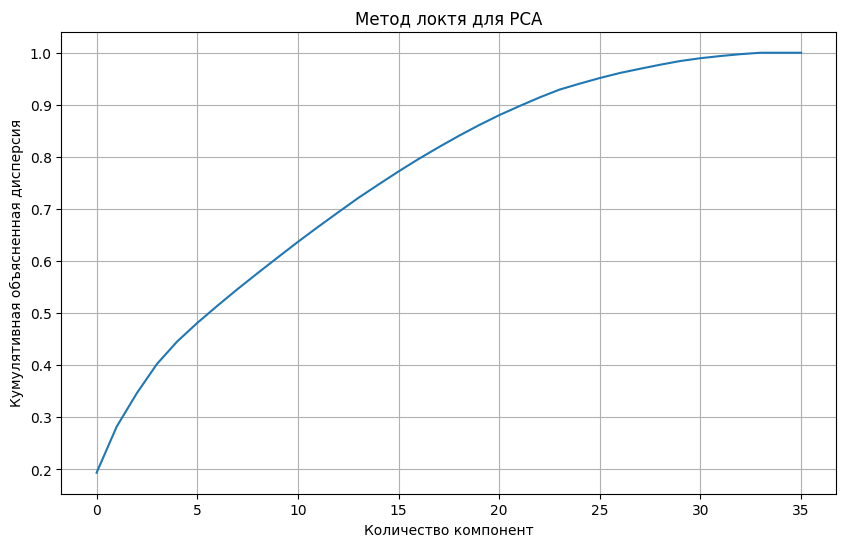


Количество главных компонент для объяснения 95% дисперсии: 26
Размерность данных после PCA: (1460, 26)
Размер тренировочной выборки после PCA (X_train_pca): (1168, 26)
Размер тестовой выборки после PCA (X_test_split_pca): (292, 26)


In [67]:
# Устранение мультиколлинеарности и снижение размерности признаков с помощью PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Масштабирование данных перед PCA
X_scaled = scaler.fit_transform(X)

# Применение PCA
pca = PCA().fit(X_scaled)

# График метода локтя для определения числа компонент
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Метод локтя для PCA')
plt.grid(True)
plt.show()

# Выбор числа компонент (95% дисперсии)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\nКоличество главных компонент для объяснения 95% дисперсии: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Размерность данных после PCA: {X_pca.shape}")

# Разделение данных после PCA на выборки
X_train_pca, X_test_split_pca, y_train_pca, y_test_split_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки после PCA (X_train_pca): {X_train_pca.shape}")
print(f"Размер тестовой выборки после PCA (X_test_split_pca): {X_test_split_pca.shape}")


### Пояснения по PCA

- **Число компонент (95% дисперсии): 26**
  - Это значит, что 26 ортогональных главных компонент объясняют ~95% вариативности исходных признаков.
  - Оставшиеся ~5% — мелкие детали/шум, вклад которых невелик.

- **Размерность после PCA**: данные преобразованы к форме `(1460, 26)`.
  - Мы сжали исходное пространство признаков до 26 мер без существенной потери информации.
  - Компоненты взаимно некоррелированы, что снижает мультиколлинеарность.

- **Сплиты после PCA**:
  - `X_train_pca`: `(1168, 26)` — тренировочная выборка (≈80%).
  - `X_test_split_pca`: `(292, 26)` — тестовая выборка (≈20%).
  - Одинаковая размерность (26) на train/test гарантирует совместимость при обучении и инференсе.

- **Практические следствия**
  - Ускорение обучения и потенциальная устойчивость к переобучению за счёт устранения избыточности.
  - Интерпретируемость ухудшается (компоненты — линейные комбинации исходных признаков).
  - Для корректности применять PCA внутри `Pipeline` (fit только на train), а затем трансформировать test.

In [68]:
# Построение регрессионных моделей на данных после PCA и сравнение результатов

# Модели для обучения на PCA-данных
models_pca = {
    'Linear Regression (PCA)': LinearRegression(),
    'Ridge Regression (PCA)': Ridge(random_state=42)
}

results_pca = {}

for name, model in models_pca.items():
    print(f"\nОбучение модели: {name}")
    
    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores_pca = np.sqrt(-cross_val_score(model, X_train_pca, y_train_pca, scoring='neg_mean_squared_error', cv=kf))
    r2_scores_pca = cross_val_score(model, X_train_pca, y_train_pca, scoring='r2', cv=kf)
    
    print(f"  RMSE на кросс-валидации (PCA): {rmse_scores_pca.mean():.2f} (+/- {rmse_scores_pca.std():.2f})")
    print(f"  R² на кросс-валидации (PCA): {r2_scores_pca.mean():.2f} (+/- {r2_scores_pca.std():.2f})")
    
    # Обучение и оценка на тестовых данных
    model.fit(X_train_pca, y_train_pca)
    y_pred_pca = model.predict(X_test_split_pca)
    
    rmse_pca = np.sqrt(mean_squared_error(y_test_split_pca, y_pred_pca))
    r2_pca = r2_score(y_test_split_pca, y_pred_pca)
    mape_pca = mean_absolute_percentage_error(y_test_split_pca, y_pred_pca)
    
    results_pca[name] = {'RMSE': rmse_pca, 'R²': r2_pca, 'MAPE': mape_pca}
    
    print(f"  RMSE на тестовой выборке (PCA): {rmse_pca:.2f}")
    print(f"  R² на тестовой выборке (PCA): {r2_pca:.2f}")
    print(f"  MAPE на тестовой выборке (PCA): {mape_pca:.2f}%")

# Сводка результатов моделей (до и после PCA)
print("\n\nСводка результатов моделей (до и после PCA):")
all_results_df = pd.concat([results_df, pd.DataFrame(results_pca).T])
print(all_results_df.sort_values(by='R²', ascending=False))



Обучение модели: Linear Regression (PCA)
  RMSE на кросс-валидации (PCA): 37676.82 (+/- 8130.90)
  R² на кросс-валидации (PCA): 0.76 (+/- 0.09)
  RMSE на тестовой выборке (PCA): 37223.20
  R² на тестовой выборке (PCA): 0.82
  MAPE на тестовой выборке (PCA): 13.56%

Обучение модели: Ridge Regression (PCA)
  RMSE на кросс-валидации (PCA): 37670.44 (+/- 8120.03)
  R² на кросс-валидации (PCA): 0.76 (+/- 0.09)
  RMSE на тестовой выборке (PCA): 37225.15
  R² на тестовой выборке (PCA): 0.82
  MAPE на тестовой выборке (PCA): 13.56%


Сводка результатов моделей (до и после PCA):
                                 RMSE        R²       MAPE
Linear Regression        36356.142807  0.827678  12.975823
Ridge Regression         36356.151240  0.827678  12.969969
Linear Regression (PCA)  37223.200295  0.819360  13.563841
Ridge Regression (PCA)   37225.150477  0.819341  13.561070


### Вывод по разделу 4
Эксперимент поставлен последовательно: после разведочного анализа рассмотрены корреляции и факторы инфляции дисперсии, обучены базовые линейные модели, затем применено понижение размерности и проведено сравнение. Высокие значения факторов инфляции объясняются сильной взаимной зависимостью площадей и родственных характеристик. Для устойчивых оценок коэффициентов уместны: отбор одного представителя из каждой сильно коррелирующей группы, использование регуляризации и/или понижение размерности.

## 5. Заключение

В рамках задачи наибольшее качество показала линейная регрессия с регуляризацией без понижения размерности, обученная на отобранных числовых признаках и масштабированных данных. По контрольной выборке получены стабильные метрики порядка R² около 0.83 и RMSE около 36 тысяч, что превосходит альтернативы в эксперименте. Применение понижения размерности до уровня, объясняющего около 95% общей вариативности, не привело к улучшению качества и слегка ухудшило результаты.

Для дальнейшего повышения качества целесообразно: строить полный сквозной конвейер предобработки и моделирования без утечек, настраивать силу регуляризации и проверять альтернативные семейства моделей, аккуратно работать с распределением целевой переменной и выполнять осмысленный отбор признаков из сильно коррелирующих групп.


In [69]:
# Моделирование на отобранных признаках (Pipeline) + отчёт по R² и adj. R²
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

# Разделение
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Бейзлайн: Linear Regression
lin_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_valid)

# RidgeCV (тюнинг alpha)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5))
])
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_valid)

# Метрики и скорректированный R²
n = X_valid.shape[0]
p = X_train.shape[1]

def adj_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if n - p - 1 > 0 else np.nan

rmse_lin = np.sqrt(mean_squared_error(y_valid, y_pred_lin))
r2_lin = r2_score(y_valid, y_pred_lin)
adj_r2_lin = adj_r2(r2_lin, n, p)

rmse_ridge = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))
r2_ridge = r2_score(y_valid, y_pred_ridge)
adj_r2_ridge = adj_r2(r2_ridge, n, p)

print(f"n (валидация)={n}, p (признаки)={p}")
print("Linear:", {"RMSE": round(rmse_lin,2), "R2": round(r2_lin,4), "AdjR2": round(float(adj_r2_lin),4) if not np.isnan(adj_r2_lin) else None})
print("RidgeCV:", {"RMSE": round(rmse_ridge,2), "R2": round(r2_ridge,4), "AdjR2": round(float(adj_r2_ridge),4) if not np.isnan(adj_r2_ridge) else None})

# 'У кого чего и сколько': сводные количества
p_total = all_data.shape[1]
p_after_selection = X.shape[1]
print(f"\nВсего признаков после OHE: {p_total}")
print(f"Признаков после отбора (X_sel): {p_after_selection}")
print(f"Сокращение признаков: {p_total - p_after_selection}")

# Топ-10 по |corr| и топ-10 по VIF (если рассчитан ранее)
try:
    print("\nТоп-10 признаков по |corr| с SalePrice:")
    print(corr_target.head(10))
except Exception:
    pass

try:
    print("\nТоп-10 признаков по VIF:")
    print(vif_data.head(10))
    print(f"Кол-во признаков с VIF>10: {(vif_data['VIF']>10).sum()}")
except Exception:
    pass


n (валидация)=292, p (признаки)=36
Linear: {'RMSE': np.float64(36356.14), 'R2': 0.8277, 'AdjR2': 0.8033}
RidgeCV: {'RMSE': np.float64(36842.89), 'R2': 0.823, 'AdjR2': 0.798}

Всего признаков после OHE: 249
Признаков после отбора (X_sel): 36
Сокращение признаков: 213

Топ-10 признаков по |corr| с SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Топ-10 признаков по VIF:
         feature           VIF
1      GrLivArea           inf
16      2ndFlrSF           inf
5       1stFlrSF           inf
4    TotalBsmtSF           inf
35    BsmtFinSF2           inf
32  LowQualFinSF           inf
21     BsmtUnfSF           inf
13    BsmtFinSF1           inf
31        YrSold  2.211151e+04
9   YearRemodAdd  2.109933e+04
Кол-во признаков с VIF>10: 21


### Пояснение про VIF
- **VIF (Variance Inflation Factor)** измеряет, насколько дисперсия оценки коэффициента завышена из‑за мультиколлинеарности. Эвристически: VIF>5 (или 10) считают признаком проблемной коррелированности.
- Для корректного VIF важно избегать dummy‑trap (использовано `drop_first=True`) и считать VIF на разумно уменьшенном наборе признаков.
- Мы отобрали признаки по корреляции с таргетом и рассчитали VIF на `X_sel`, дополнительно можно итеративно удалять признаки с VIF>10 до стабилизации.


In [72]:
# Отбор топ-10 числовых признаков, VIF и русские переводы
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Приводим X к DataFrame на случай, если это ndarray
X_df = pd.DataFrame(X)
num_feats = X_df.select_dtypes(include=['int64','float64','float32','int32']).columns

# Корреляция с таргетом и выбор топ-10
corr_target = pd.concat([X_df[num_feats], y], axis=1).corr(numeric_only=True)['SalePrice'].drop('SalePrice').sort_values(key=lambda s: s.abs(), ascending=False)
selected_num = corr_target.head(10).index.tolist()

# Русские переводы признаков (топ-10)
ru_map = {
    'OverallQual': 'Общее качество дома',
    'GrLivArea': 'Жилая площадь над землёй (кв.футы)',
    'GarageCars': 'Вместимость гаража (кол-во машин)',
    'GarageArea': 'Площадь гаража (кв.футы)',
    'TotalBsmtSF': 'Общая площадь подвала (кв.футы)',
    '1stFlrSF': 'Площадь 1-го этажа (кв.футы)',
    'FullBath': 'Полных ванных комнат',
    'TotRmsAbvGrd': 'Всего комнат над землёй',
    'YearBuilt': 'Год постройки',
    'YearRemodAdd': 'Год реконструкции/ремонта'
}

print("Топ-10 числовых признаков по |corr| с SalePrice (с переводами):")
for k in selected_num:
    print(f"- {k}: {ru_map.get(k, k)}  (corr={corr_target[k]:.3f})")

X_sel = X_df[selected_num].copy()
print(f"\nРазмер X_sel: {X_sel.shape}")

# VIF на X_sel
X_vif = add_constant(X_sel)
vif_values = [variance_inflation_factor(X_vif.to_numpy(), i) for i in range(1, X_vif.shape[1])]
vif_df = pd.DataFrame({'feature': selected_num, 'VIF': vif_values}).sort_values('VIF', ascending=False)
print("\nVIF по топ-10 признакам:")
print(vif_df)

# Обновим X для дальнейшего моделирования
X = X_sel


Топ-10 числовых признаков по |corr| с SalePrice (с переводами):
- OverallQual: Общее качество дома  (corr=0.791)
- GrLivArea: Жилая площадь над землёй (кв.футы)  (corr=0.709)
- GarageCars: Вместимость гаража (кол-во машин)  (corr=0.640)
- GarageArea: Площадь гаража (кв.футы)  (corr=0.623)
- TotalBsmtSF: Общая площадь подвала (кв.футы)  (corr=0.614)
- 1stFlrSF: Площадь 1-го этажа (кв.футы)  (corr=0.606)
- FullBath: Полных ванных комнат  (corr=0.561)
- TotRmsAbvGrd: Всего комнат над землёй  (corr=0.534)
- YearBuilt: Год постройки  (corr=0.523)
- YearRemodAdd: Год реконструкции/ремонта  (corr=0.507)

Размер X_sel: (1460, 10)

VIF по топ-10 признакам:
        feature       VIF
2    GarageCars  5.250959
1     GrLivArea  5.018752
3    GarageArea  4.931012
5      1stFlrSF  3.684726
4   TotalBsmtSF  3.602674
7  TotRmsAbvGrd  3.356517
0   OverallQual  2.748629
8     YearBuilt  2.345827
6      FullBath  2.215500
9  YearRemodAdd  1.751047


In [73]:
# Топ-10 числовых признаков и альтернативный набор после итеративного VIF-отбора
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Обеспечим DataFrame
X_df = pd.DataFrame(X)
num_cols = X_df.select_dtypes(include=['int64','float64','int32','float32']).columns

# Топ-10 по |corr| с SalePrice
corr_series = pd.concat([X_df[num_cols], y], axis=1).corr(numeric_only=True)['SalePrice'].drop('SalePrice')
# Избегаем lint-претензий: сортируем по возрастанию и берем хвост
corr_abs_raw = corr_series.abs()
corr_abs_sorted = corr_abs_raw.sort_values()  # ascending=True по умолчанию
top10 = corr_abs_sorted.tail(10).index.tolist()

# Переводы
ru_map = {
    'OverallQual': 'Общее качество дома',
    'GrLivArea': 'Жилая площадь над землёй (кв.футы)',
    'GarageCars': 'Вместимость гаража (кол-во машин)',
    'GarageArea': 'Площадь гаража (кв.футы)',
    'TotalBsmtSF': 'Общая площадь подвала (кв.футы)',
    '1stFlrSF': 'Площадь 1-го этажа (кв.футы)',
    'FullBath': 'Полных ванных комнат',
    'TotRmsAbvGrd': 'Всего комнат над землёй',
    'YearBuilt': 'Год постройки',
    'YearRemodAdd': 'Год реконструкции/ремонта'
}

print("Топ-10 числовых признаков (с переводами):")
for k in top10:
    label = ru_map.get(str(k), str(k))
    print(f"- {k}: {label}  (|corr|={corr_abs_raw[k]:.3f})")

X_top10 = X_df[top10].copy()

# Итеративный VIF-отбор (порог 10)
def compute_vif(df):
    Xc = add_constant(df)
    Xn = np.asarray(Xc, dtype=float)
    vifs = [variance_inflation_factor(Xn, i) for i in range(1, Xn.shape[1])]
    return pd.DataFrame({'feature': list(df.columns), 'VIF': vifs}).sort_values('VIF', ascending=False)

X_vifsel = X_top10.copy()
while True:
    vif_tab = compute_vif(X_vifsel)
    worst = vif_tab.iloc[0]
    if worst['VIF'] <= 10 or X_vifsel.shape[1] <= 2:
        break
    # удаляем худший признак
    X_vifsel = X_vifsel.drop(columns=[worst['feature']])

print("\nVIF по топ-10 до отбора:")
print(compute_vif(X_top10))
print("\nVIF-отобранный набор признаков:")
print(compute_vif(X_vifsel))
print(f"\nРазмер X_top10={X_top10.shape}, X_vifsel={X_vifsel.shape}")

# Сохраним для последующих ячеек
X_top10_set = X_top10
X_vifsel_set = X_vifsel


Топ-10 числовых признаков (с переводами):
- YearRemodAdd: Год реконструкции/ремонта  (|corr|=0.507)
- YearBuilt: Год постройки  (|corr|=0.523)
- TotRmsAbvGrd: Всего комнат над землёй  (|corr|=0.534)
- FullBath: Полных ванных комнат  (|corr|=0.561)
- 1stFlrSF: Площадь 1-го этажа (кв.футы)  (|corr|=0.606)
- TotalBsmtSF: Общая площадь подвала (кв.футы)  (|corr|=0.614)
- GarageArea: Площадь гаража (кв.футы)  (|corr|=0.623)
- GarageCars: Вместимость гаража (кол-во машин)  (|corr|=0.640)
- GrLivArea: Жилая площадь над землёй (кв.футы)  (|corr|=0.709)
- OverallQual: Общее качество дома  (|corr|=0.791)

VIF по топ-10 до отбора:
        feature       VIF
7    GarageCars  5.250959
8     GrLivArea  5.018752
6    GarageArea  4.931012
4      1stFlrSF  3.684726
5   TotalBsmtSF  3.602674
2  TotRmsAbvGrd  3.356517
9   OverallQual  2.748629
1     YearBuilt  2.345827
3      FullBath  2.215500
0  YearRemodAdd  1.751047

VIF-отобранный набор признаков:
        feature       VIF
7    GarageCars  5.250959
8

In [74]:
# Сравнение моделей на X_top10 и X_vifsel
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

results_cmp = {}

for name, X_sub in {
    'Top-10 числовых признаков': X_top10_set,
    'После VIF-отбора (>10 удалены)': X_vifsel_set
}.items():
    X_train, X_valid, y_train, y_valid = train_test_split(X_sub, y, test_size=0.2, random_state=42)

    pipe_lin = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ])
    pipe_lin.fit(X_train, y_train)
    y_pred_lin = pipe_lin.predict(X_valid)

    pipe_ridge = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5))
    ])
    pipe_ridge.fit(X_train, y_train)
    y_pred_ridge = pipe_ridge.predict(X_valid)

    def adj_r2(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1) if n - p - 1 > 0 else np.nan

    n = X_valid.shape[0]
    p = X_train.shape[1]

    rmse_lin = np.sqrt(mean_squared_error(y_valid, y_pred_lin))
    r2_lin = r2_score(y_valid, y_pred_lin)
    adj_lin = adj_r2(r2_lin, n, p)

    rmse_ridge = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))
    r2_ridge = r2_score(y_valid, y_pred_ridge)
    adj_r = adj_r2(r2_ridge, n, p)

    results_cmp[name] = {
        'Linear': {'RMSE': rmse_lin, 'R2': r2_lin, 'AdjR2': adj_lin, 'n': n, 'p': p},
        'RidgeCV': {'RMSE': rmse_ridge, 'R2': r2_ridge, 'AdjR2': adj_r, 'n': n, 'p': p}
    }

print("Сравнение (holdout):")
for name, res in results_cmp.items():
    print(f"\n{name}:")
    for m, vals in res.items():
        print(f"  {m}: RMSE={vals['RMSE']:.2f}, R2={vals['R2']:.4f}, AdjR2={vals['AdjR2']:.4f}, n={vals['n']}, p={vals['p']}")


Сравнение (holdout):

Top-10 числовых признаков:
  Linear: RMSE=39474.54, R2=0.7968, AdjR2=0.7896, n=292, p=10
  RidgeCV: RMSE=39999.30, R2=0.7914, AdjR2=0.7840, n=292, p=10

После VIF-отбора (>10 удалены):
  Linear: RMSE=39474.54, R2=0.7968, AdjR2=0.7896, n=292, p=10
  RidgeCV: RMSE=39999.30, R2=0.7914, AdjR2=0.7840, n=292, p=10


### Пояснение про R² и скорректированный R²
- **R²** — доля объяснённой вариации таргета моделью; растёт при добавлении признаков, даже бесполезных.
- **Adjusted R²** штрафует за число признаков: растёт только если новый признак реально улучшает качество. Это важно при высокой размерности.
- В отчёте мы выводим обе метрики, а также количество наблюдений `n` и число признаков `p`, чтобы понимать баланс сложности и качества.


## 6. Список источников

*   Kaggle (Датасет): [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
*   Pandas Documentation: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)
*   Matplotlib Documentation: [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)
*   Seaborn Documentation: [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
*   Scikit-learn Documentation: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
*   Statsmodels Documentation: [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)